In [3]:
import os
import re
import sys
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

from functools import partial

from scipy.stats import uniform
from numba_stats import truncnorm, truncexpon, norm, expon

from iminuit import cost
from iminuit import Minuit

from jacobi import propagate

In [2]:
!pip install jacobi

In [4]:
### Import functions from peak_functions

repository_path = os.path.abspath('../..')
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [5]:
filename = '/Users/romoluque_c/LEGEND/BACON/datatest/run-11_20_2023-file_1.root'
infile   = uproot.open(filename)
RawTree  = infile['RawTree']

In [6]:
evts_path = '/Users/romoluque_c/LEGEND/BACON/data_npz/'

normal_chs  = range(9)
trigger_chs = [9, 10, 11]

filt_evts_all             = {}
idx_peaks_ch_all          = {}
height_peaks_ch_all       = {}
idx_peaks_ch_trigg_all    = {}
height_peaks_ch_trigg_all = {}

def extract_date_and_number(filename):
    match = re.search(r"(\d{2}_\d{2}_\d{4})-file_(\d+)", filename)
    return match.group(1), int(match.group(2))

def adapt_evt_id(evt_id, fnum):
    return 1000000*fnum + np.array(evt_id)

files        = os.listdir(evts_path)
filt_files   = [file for file in files if file.startswith("BACoN_hits_and_times_run-11_20")]
sorted_files = sorted(filt_files, key=extract_date_and_number)

for filename in sorted_files[1:2]:
    my_file    = evts_path+filename
    d          = np.load(my_file, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
    print(date, fnum)
        
    if date not in filt_evts_all:
        filt_evts_all            [date] = d['filt_evts_dict']            .item()
        idx_peaks_ch_all         [date] = d['idx_peaks_ch_dict']         .item()
        height_peaks_ch_all      [date] = d['height_peaks_ch_dict']      .item()
        idx_peaks_ch_trigg_all   [date] = d['idx_peaks_ch_trigg_dict']   .item()
        height_peaks_ch_trigg_all[date] = d['height_peaks_ch_trigg_dict'].item()
        continue
    
    for ch in normal_chs:
        try:
            filt_evts_all            [date][ch] = np.concatenate((filt_evts_all      [date][ch], adapt_evt_id(d['filt_evts_dict'].item()[ch], fnum)))
            idx_peaks_ch_all         [date][ch] = np.concatenate((idx_peaks_ch_all   [date][ch], d['idx_peaks_ch_dict']          .item()[ch]))
            height_peaks_ch_all      [date][ch] = np.concatenate((height_peaks_ch_all[date][ch], d['height_peaks_ch_dict']       .item()[ch]))
        except ValueError:
            print(date, fnum, filename, ch)
            continue

        for ch in trigger_chs:
            idx_peaks_ch_trigg_all   [date][ch] = np.concatenate((idx_peaks_ch_trigg_all   [date][ch], d['idx_peaks_ch_trigg_dict']   .item()[ch]))
            height_peaks_ch_trigg_all[date][ch] = np.concatenate((height_peaks_ch_trigg_all[date][ch], d['height_peaks_ch_trigg_dict'].item()[ch]))

11_20_2023 1


In [7]:
signal_evts = np.unique(np.concatenate(list(filt_evts_all['11_20_2023'].values())))

wfs_evts_with_peaks = {ch: pf.wfs_from_rawtree(RawTree, ch)[signal_evts.astype(int)]
                       for ch in normal_chs}

max_smpl_bsl  = 650
subt_wfs_dict = {ch: pf.subtract_baseline(wfs_evts_with_peaks[ch], mode=True, wf_range_bsl=(0, max_smpl_bsl))
                 for ch in range(9)}

In [8]:
summed_swfs_norm_join_evts_dict = {ch: np.sum(subt_wfs_dict[ch], axis=0)/len(subt_wfs_dict[ch])
                                   for ch in normal_chs}

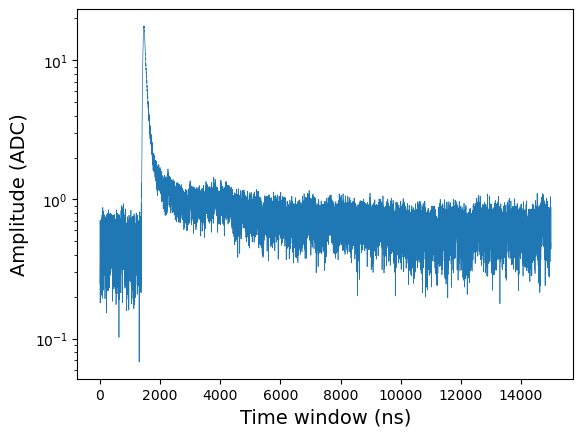

In [9]:
sel_ch = 0
sum_wfs_norm_cal = summed_swfs_norm_join_evts_dict[sel_ch]
plt.plot(2*np.arange(len(sum_wfs_norm_cal)), sum_wfs_norm_cal, linewidth=0.5)
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.yscale('log')
plt.show()

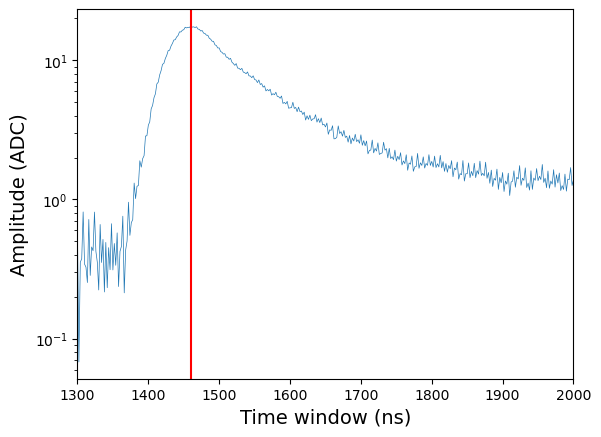

In [10]:
sel_ch = 0
sum_wfs_norm_cal = summed_swfs_norm_join_evts_dict[sel_ch]
plt.plot(2*np.arange(len(sum_wfs_norm_cal)), sum_wfs_norm_cal, linewidth=0.5)
plt.axvline(x=1460, color='r')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.yscale('log')
plt.xlim(1300, 2000)
plt.show()

#### Select range to reproduce Rosanna's fit

In [11]:
data = sum_wfs_norm_cal[int(1460/2):int(1460/2)+2500]

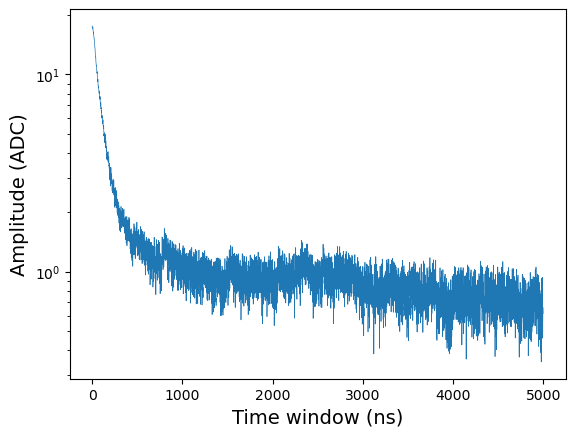

In [12]:
plt.plot(2*np.arange(len(data)), data, linewidth=0.5)
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.yscale('log')
plt.show()

### Check fit function

In [13]:
def integral_all_free(x, b, tau1, s1, s2, tau2):
    """
    b:    singlet ratio (1/3, the triplet ratio would be 2/3)
    tau1: exp decay singlet
    s1:   signal strength (% signal)
    s2:   bkg strength (% bkg)
    tau2: exp decay singlet
    
    If there are counts on the left of the peak, a different range to that function can be provided.
    """
    return s1 * ( (  b  * truncexpon.cdf(x, *xr, 0.0, tau1) 
                + (1-b) * truncexpon.cdf(x, *xr, 0.0, tau2))) + s2 * uniform.cdf(x, *xr)

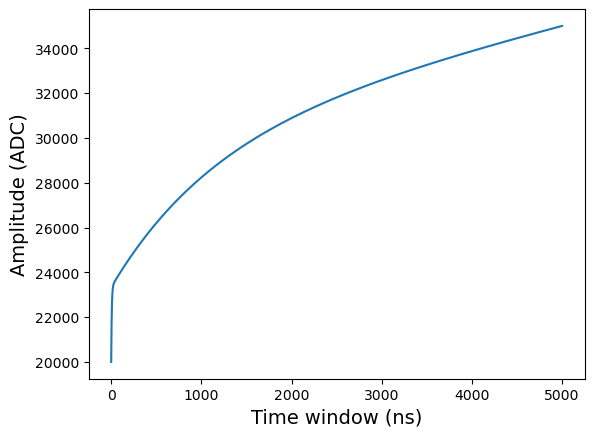

In [14]:
xr    = (0,5000)
xvals = np.arange(xr[0], xr[1], 0.1)
plt.plot(xvals, 20000+integral_all_free(xvals, b=1/3, tau1=6, s1=10000, s2=5000, tau2=1160))
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
#plt.yscale('log')
plt.show()

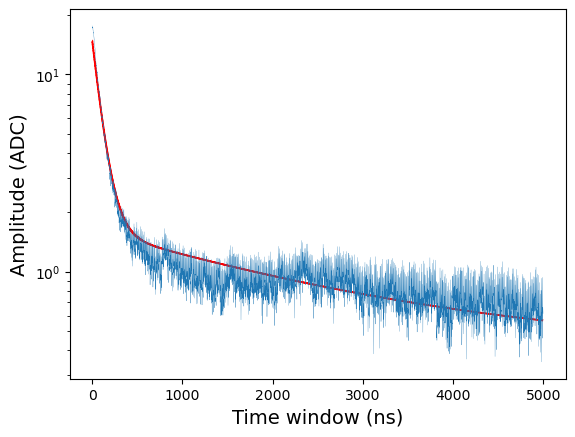

In [19]:
n, xe = data[1:], 2*np.arange(len(data))
plt.plot(2*np.arange(len(data)), data, linewidth=0.2)
plt.stairs(np.diff(integral_all_free(xe, b=1/3, tau1=100, s1=2000, s2=1000, tau2=2500)), xe, baseline=None,  linewidth=1.2, color="r")
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.yscale('log')
plt.show()

## Fit

In [20]:
len(data), np.sum(data)

(2500, 3032.9482)

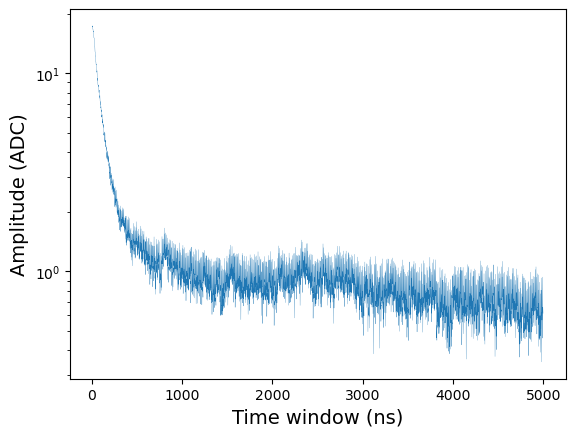

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 93.84 (χ²/ndof = 0.0)      │              Nfcn = 700              │
│ EDM = 9.78e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

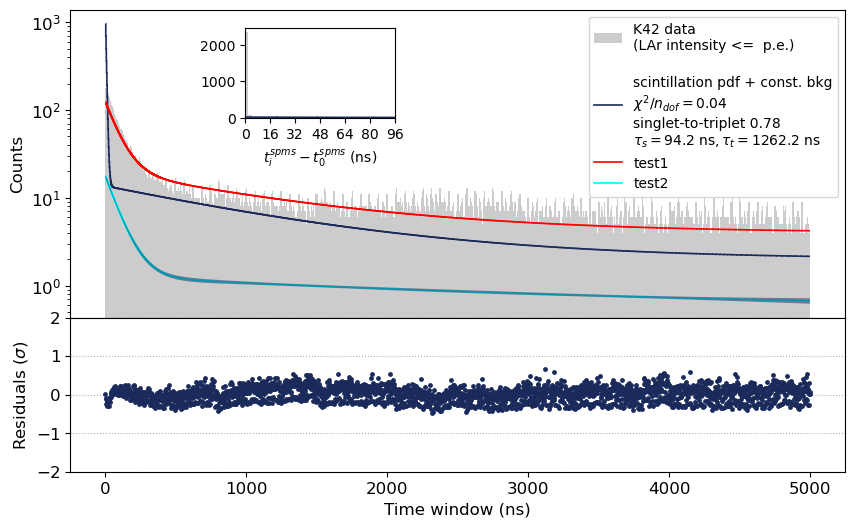

In [23]:
xr = (0,5000)

n, xe = data[1:], 2*np.arange(len(data))

plt.plot(xe[1:], n, linewidth=0.2)
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.yscale('log')
plt.show()


fig, (ax, ax2) = plt.subplots(2,1,figsize = (10,6), gridspec_kw={'height_ratios': [2, 1]})

cx = 0.5 * (xe[1:] + xe[:-1])
c  = cost.ExtendedBinnedNLL(n, xe, integral_all_free)

left_lim  = 0
right_lim = 5000
c.mask    = (cx > left_lim) & (cx < right_lim)

m = Minuit(c, b=1/3, tau1=6, s1=10000, s2=5000, tau2=1160)
#m = Minuit(c, b=1/3, tau1=100, s1=2000, s2=1000, tau2=2500)
m.limits[0] = (0, 1)
m.limits[1] = (0,100)

print(m.migrad())
print(m.fval)

chi2 = m.fval / (len(xe) - m.nfit)
chi2 = np.around(chi2, 2)
print(f'chi2: {chi2:.2f}')

data_hist = np.hstack(np.array([i*np.ones(int(j*10)) for i,j in zip(2*np.arange(len(data)), data)], dtype=object))
ax.hist(data_hist, bins = xe, color = "#CCCCCC",
        label = f"K42 data\n(LAr intensity <=  p.e.)")

lw = 1.2
fs = 12

signal_to_bkg = np.around(m.values[2]/m.values[3], 2)
sig_to_trip   = m.values[0]/(1-m.values[0])
print(m.values)
ax.stairs(np.diff(integral_all_free(xe, b=1/3, tau1=6, s1=10000, s2=5000, tau2=1160)), xe, baseline=None,  linewidth = lw,
            label=f"\nscintillation pdf + const. bkg\n"+r'$\chi^2/n_{dof} = $'+f'{chi2:.2f}'+f'\nsinglet-to-triplet {sig_to_trip:.2f}\n'+r'$\tau_s = $'+f'{m.values[1]:.1f} ns' +r'$, \tau_t = $'+f'{m.values[3]:.1f} ns', color = "#1A2A5B") # \n S/B = {signal_to_bkg:.2f}
ax.stairs(np.diff(integral_all_free(xe, b=1/3, tau1=90, s1=14000, s2=10000, tau2=1160)), xe, baseline=None,  linewidth = lw,
            label="test1", color = "r") # \n S/B = {signal_to_bkg:.2f}
ax.stairs(np.diff(integral_all_free(xe, *m.values)), xe, baseline=None,  linewidth = lw,
            label="test2", color = "cyan") # \n S/B = {signal_to_bkg:.2f}

y, ycov = propagate(lambda p: np.diff(integral_all_free(xe, *p)), m.values, m.covariance)
yerr_prop = np.diag(ycov) ** 0.5
ax.fill_between(cx, y - yerr_prop, y + yerr_prop, facecolor="#1A2A5B", alpha=0.5)

# Add an inset
left, bottom, width, height = [0.3, 0.7, 0.15, 0.15]
inset_ax = fig.add_axes([left, bottom, width, height])
inset_ax.hist(data, bins = xe, color = "#CCCCCC")
inset_ax.stairs(np.diff(integral_all_free(xe, *m.values)), xe, baseline=None,  linewidth = lw,
            label=rf"fit", color = "#1A2A5B")
inset_ax.set_xlim(0, 96)  # Set the x-axis limit for the inset
bin_size = 16
inset_ax.set_xticks([i * bin_size for i in range(0, 7)])
inset_ax.set_yticks([0,1000,2000])
inset_ax.set_xlabel(r'$t_i^{spms} - t_0^{spms}$ (ns)')

residuals = (np.diff(integral_all_free(xe, *m.values)) - n) / np.sqrt(n)
ax2.scatter(cx, residuals, s=6, color = '#1A2A5B')
ax2.set_axisbelow(True)
ax2.set_yticks([-2, -1, 0, 1, 2])
ax2.minorticks_off()
ax2.yaxis.grid(True, linestyle=':')

ax.set_ylabel('Counts', fontsize=fs)
ax2.set_xlabel('Time window (ns)', fontsize=fs)
ax2.set_ylabel('Residuals ($\sigma$)', fontsize=fs)

ax.set_xticks([])
ax.set_yscale("log")
fig.subplots_adjust(wspace=0, hspace=0)
plt.subplots_adjust(wspace=0, hspace=0)

handles, labels = ax.get_legend_handles_labels()
order = [0, 1, 2, 3]
ax .legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'upper right', fontsize=fs-2)
ax .tick_params(axis='both', which='major', labelsize=fs)
ax2.tick_params(axis='both', which='major', labelsize=fs)

### Now try to adjust the fit to my actual plot

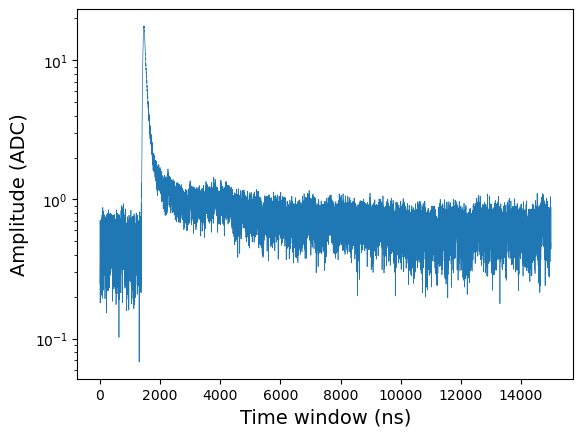

In [154]:
sel_ch = 0
sum_wfs_norm_cal = summed_swfs_norm_join_evts_dict[sel_ch]
plt.plot(2*np.arange(len(sum_wfs_norm_cal)), sum_wfs_norm_cal, linewidth=0.5)
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.yscale('log')
plt.show()

In [155]:
def integral_all_free_peak_not_centered(x, b, tau1, s1, s2, tau2):
    """
    b:    singlet ratio (1/3, the triplet ratio would be 2/3)
    tau1: exp decay singlet
    s1:   signal strength (% signal)
    s2:   bkg strength (% bkg)
    tau2: exp decay singlet
    
    If there are counts on the left of the peak, a different range to that function can be provided.
    """
    xr  = (1460, 15000)
    xr2 = (   0, 15000)
    return s1 * ( (  b  * truncexpon.cdf(x, *xr, 0.0, tau1) 
                + (1-b) * truncexpon.cdf(x, *xr, 0.0, tau2))) + s2 * uniform.cdf(x, *xr2)

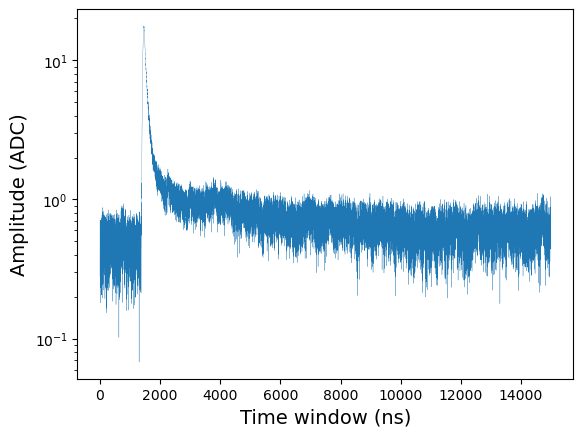

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = nan                        │              Nfcn = 441              │
│ EDM = nan (Goal: 0.0002)         │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

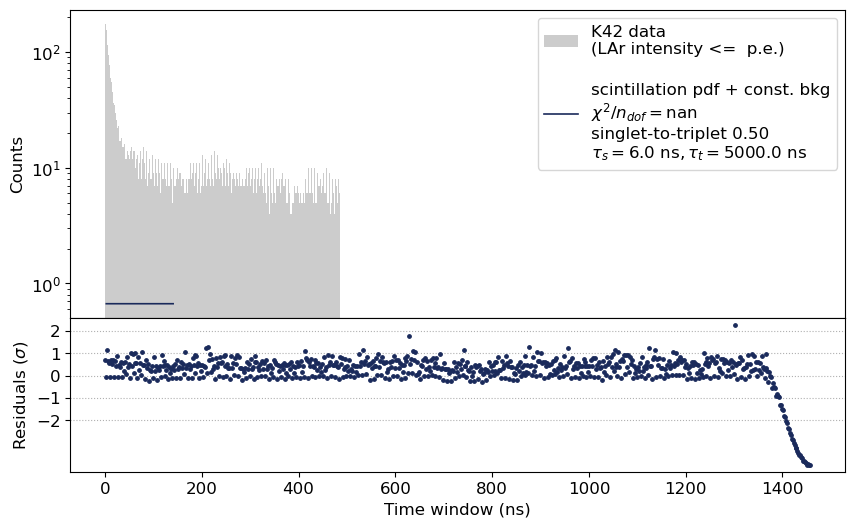

In [159]:
n, xe = sum_wfs_norm_cal[1:], 2*np.arange(len(sum_wfs_norm_cal))

plt.plot(xe[1:], n, linewidth=0.2)
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.yscale('log')
plt.show()


fig, (ax, ax2) = plt.subplots(2,1,figsize = (10,6), gridspec_kw={'height_ratios': [2, 1]})

cx = 0.5 * (xe[1:] + xe[:-1])
c  = cost.ExtendedBinnedNLL(n, xe, integral_all_free_peak_not_centered)

##left_lim  =  1460
##right_lim = 15000
##c.mask    = (cx > left_lim) & (cx < right_lim)

m = Minuit(c, b=1/3, tau1=6, s1=10000, s2=5000, tau2=1160)
#m = Minuit(c, b=1/3, tau1=100, s1=2000, s2=1000, tau2=2500)
#m.limits[0] = (0, 1)
#m.limits[1] = (0,100)

print(m.migrad())
print(m.fval)

chi2 = m.fval / (len(xe) - m.nfit)
chi2 = np.around(chi2, 2)
print(f'chi2: {chi2:.2f}')

data_hist = np.hstack(np.array([i*np.ones(int(j*10)) for i,j in zip(2*np.arange(len(data)), data)], dtype=object))
ax.hist(data_hist, bins = xe, color = "#CCCCCC",
        label = f"K42 data\n(LAr intensity <=  p.e.)")

lw = 1.2
fs = 12

signal_to_bkg = np.around(m.values[2]/m.values[3], 2)
sig_to_trip   = m.values[0]/(1-m.values[0])
print(m.values)
ax.stairs(np.diff(integral_all_free_peak_not_centered(xe, b=1/3, tau1=6, s1=10000, s2=5000, tau2=1160)), xe, baseline=None,  linewidth = lw,
            label=f"\nscintillation pdf + const. bkg\n"+r'$\chi^2/n_{dof} = $'+f'{chi2:.2f}'+f'\nsinglet-to-triplet {sig_to_trip:.2f}\n'+r'$\tau_s = $'+f'{m.values[1]:.1f} ns' +r'$, \tau_t = $'+f'{m.values[3]:.1f} ns', color = "#1A2A5B") # \n S/B = {signal_to_bkg:.2f}

#y, ycov = propagate(lambda p: np.diff(integral_all_free(xe, p)), *m.values, m.covariance)
#yerr_prop = np.diag(ycov) ** 0.5
### ax.fill_between(cx, y - yerr_prop, y + yerr_prop, facecolor="#1A2A5B", alpha=0.5)
### 
##### # Add an inset
##### left, bottom, width, height = [0.3, 0.7, 0.15, 0.15]
##### inset_ax = fig.add_axes([left, bottom, width, height])
##### inset_ax.hist(data, bins = xe, color = "#CCCCCC")
##### inset_ax.stairs(np.diff(integral_all_free(xe, *m.values)), xe, baseline=None,  linewidth = lw,
#####             label=rf"fit", color = "#1A2A5B")
##### inset_ax.set_xlim(0, 96)  # Set the x-axis limit for the inset
##### bin_size = 16
##### inset_ax.set_xticks([i * bin_size for i in range(0, 7)])
##### inset_ax.set_yticks([0,1000,2000])
##### inset_ax.set_xlabel(r'$t_i^{spms} - t_0^{spms}$ (ns)')

residuals = (np.diff(integral_all_free_peak_not_centered(xe, *m.values)) - n) / np.sqrt(n)
ax2.scatter(cx, residuals, s=6, color = '#1A2A5B')
ax2.set_axisbelow(True)
ax2.set_yticks([-2, -1, 0, 1, 2])
ax2.minorticks_off()
ax2.yaxis.grid(True, linestyle=':')

ax.set_ylabel('Counts', fontsize=fs)
ax2.set_xlabel('Time window (ns)', fontsize=fs)
ax2.set_ylabel('Residuals ($\sigma$)', fontsize=fs)

ax.set_xticks([])
ax.set_yscale("log")
fig.subplots_adjust(wspace=0, hspace=0)
plt.subplots_adjust(wspace=0, hspace=0)

handles, labels = ax.get_legend_handles_labels()
order = [0,1]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'upper right', fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
ax2.tick_params(axis='both', which='major', labelsize=fs)

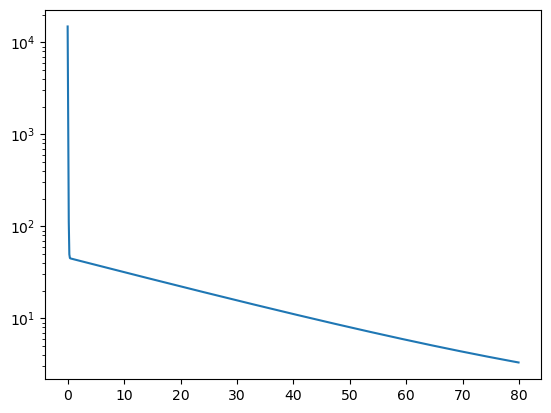

In [197]:
import numpy as np

def double_exponential_with_rise(t, amplitude1, decay_constant1, amplitude2, decay_constant2, rise_time, offset):
    rise_term = np.piecewise(t, [t < rise_time, t >= rise_time],
                             [lambda t: amplitude1 * (1 - np.exp(-t / decay_constant1)),
                              lambda t: amplitude1 * (1 - np.exp(-rise_time / decay_constant1)) * np.exp(-(t - rise_time) / decay_constant2)])
    
    decay_term = amplitude2 * np.exp(-decay_constant2 * (t - rise_time))
    
    return rise_term + decay_term + offset

# Example usage:
time_values = np.arange(0, 80, 0.1)
amplitude1 = 1000
decay_constant1 = 2.2
amplitude2 = 1000
decay_constant2 = 27
rise_time = 0.1
offset = 1

signal_values = double_exponential_with_rise(time_values, amplitude1, decay_constant1, amplitude2, decay_constant2, rise_time, offset)

plt.plot(time_values, signal_values)
plt.yscale('log');

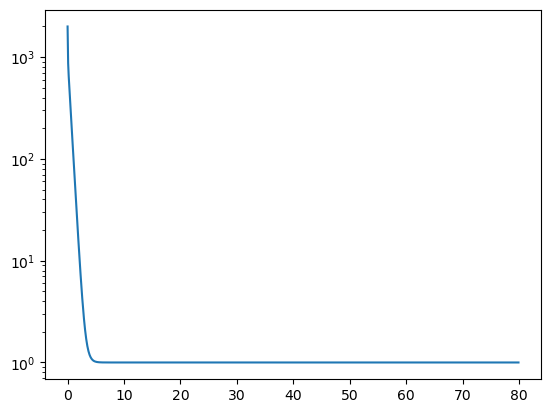

In [196]:
import numpy as np

def double_exponential_decay(t, amplitude1, decay_constant1, amplitude2, decay_constant2, offset):
    return amplitude1 * np.exp(-decay_constant1 * t) + amplitude2 * np.exp(-decay_constant2 * t) + offset

# Example usage:
time_values = np.arange(0, 80, 0.1)
amplitude1 = 1000
decay_constant1 = 2.2
amplitude2 = 1000
decay_constant2 = 27
offset = 1

decay_values = double_exponential_decay(time_values, amplitude1, decay_constant1, amplitude2, decay_constant2, offset)

plt.plot(time_values, decay_values)
plt.yscale('log');